# Named Entity Linking with BERT

## Using BERT embeddings to aid in the task of End-to-End Named Entity Linking

### Task 1 - Read in the annotations and training dataset from AIDA-YAGO2 as well as the Wiki Entity Name/Id dataset

These tab-seperated files will be used to train our model

In [1]:
annotations_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\data\\AIDA-YAGO2-annotations.tsv'

In [324]:
import csv
import re

train_annotations = []
val_annotations = []
test_annotations = []

with open(annotations_file, encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    i = 0
    for row in reader:
        i += 1
        train_annotations.append(row)
        if row == ['-DOCSTART- (947testa CRICKET)']: # first validation document
            #print('validation data starts at index:', i-1)
            val_index = i-1
        if row == ['-DOCSTART- (1163testb SOCCER)']: # first test document
            #print('test data starts at index:', i-1)
            test_index = i-1
    
    val_annotations = train_annotations[val_index: test_index]
    test_annotations = train_annotations[test_index:]
    train_annotations = train_annotations[:val_index]
    
print('train mentions: ', len(train_annotations))
print('validation mentions: ', len(val_annotations))
print('test mentions: ', len(test_annotations))            

train mentions:  25288
validation mentions:  6349
test mentions:  6078


In [3]:
train_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\data\\basic_data\\test_datasets\\AIDA\\aida_train_unquoted.txt'

In [4]:
train_data_raw = []

with open(train_file, encoding='utf-8') as train_tsvfile:
    train_reader = csv.reader(train_tsvfile, delimiter='\t')
    for row in train_reader:
        train_data_raw.append(row)
    
train_data_raw[:490] # just show up to the second document

[['-DOCSTART- (1 EU)'],
 ['EU', 'B', 'EU', '--NME--'],
 ['rejects'],
 ['German',
  'B',
  'German',
  'Germany',
  'http://en.wikipedia.org/wiki/Germany',
  '11867',
  '/m/0345h'],
 ['call'],
 ['to'],
 ['boycott'],
 ['British',
  'B',
  'British',
  'United_Kingdom',
  'http://en.wikipedia.org/wiki/United_Kingdom',
  '31717',
  '/m/07ssc'],
 ['lamb'],
 ['.'],
 [],
 ['Peter', 'B', 'Peter Blackburn', '--NME--'],
 ['Blackburn', 'I', 'Peter Blackburn', '--NME--'],
 [],
 ['BRUSSELS',
  'B',
  'BRUSSELS',
  'Brussels',
  'http://en.wikipedia.org/wiki/Brussels',
  '3708',
  '/m/0177z'],
 ['1996-08-22'],
 [],
 ['The'],
 ['European',
  'B',
  'European Commission',
  'European_Commission',
  'http://en.wikipedia.org/wiki/European_Commission',
  '9974',
  '/m/02q9k'],
 ['Commission',
  'I',
  'European Commission',
  'European_Commission',
  'http://en.wikipedia.org/wiki/European_Commission',
  '9974',
  '/m/02q9k'],
 ['said'],
 ['on'],
 ['Thursday'],
 ['it'],
 ['disagreed'],
 ['with'],
 ['Germa

In [5]:
# create raw validation and test datasets
test_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\data\\basic_data\\test_datasets\\AIDA\\testa_testb_aggregate_unquoted.txt'

validation_data_raw = []
test_data_raw = []

with open(test_file, encoding='utf-8') as test_tsvfile:
    test_reader = csv.reader(test_tsvfile, delimiter='\t')
    for row in test_reader:
        validation_data_raw.append(row)

for i in range(len(validation_data_raw)):
    if validation_data_raw[i] == ['-DOCSTART- (1163testb SOCCER)']: # first test document
        test_index = i
        
test_data_raw = validation_data_raw[test_index:]
validation_data_raw = validation_data_raw[:test_index]

In [6]:
wikiName_id_mapFile = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\data\\basic_data\\wiki_name_id_map.txt'

In [7]:
with open(wikiName_id_mapFile, encoding='utf-8') as wikiMap_tsvfile:
    wikiMap_reader = csv.reader(wikiMap_tsvfile, delimiter='\t')
    wikiName_id_map_dict = {int(row[1]): row[0] for row in wikiMap_reader if row[0][0].isalpha() or row[0][0].isnumeric()}

wikiName_id_map_dict[31717]

'United Kingdom'

### Task 2 - Pre-process the training data

In [8]:
# Import modules that will be used downstream

import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from datetime import datetime

In [13]:
local_bert_path = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\bert'
# local path where the bert module has been cloned from git

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)

In [14]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

W1120 19:29:01.032282 17076 deprecation_wrapper.py:119] From C:\Users\andre\Documents\Berkeley\w266\w266_project\bert\optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [15]:
# Use the bert model that is cased
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

Create a BERT tokenizer so that words can be tokenized for BERT input

In [16]:
bert_module = hub.Module(bert_url)
tokenization_info = bert_module(signature="tokenization_info", as_dict=True)

vocab_file, do_lower_case = tf.Session().run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])

tokenizer = tokenization.FullTokenizer(
    vocab_file = vocab_file, do_lower_case = do_lower_case
)

W1120 19:29:15.015879 17076 deprecation_wrapper.py:119] From C:\Users\andre\Documents\Berkeley\w266\w266_project\bert\tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [17]:
# Make sure the tokenizer works
tokenizer_test = tokenizer.tokenize('This tokenizer, is it even working?')
tokenizer_test

['This', 'token', '##izer', ',', 'is', 'it', 'even', 'working', '?']

In [18]:
tokenizer_ids_test = tokenizer.convert_tokens_to_ids(tokenizer_test)
tokenizer_ids_test

[1188, 22559, 17260, 117, 1110, 1122, 1256, 1684, 136]

In [19]:
tokenizer.convert_ids_to_tokens(tokenizer_ids_test)
# seems legit

['This', 'token', '##izer', ',', 'is', 'it', 'even', 'working', '?']

Now the BERT tokenizer can be used to create tokens from the input text that can be used by the BERT model (more on that later).

To simplify things, create a function that creates dictionary objects for document text, NER tags, entity Ids, and wikipedia URLs given row-by-row data (from training or test set)

In [294]:
len(train_data_raw)

218505

In [20]:
def createUtilityDicts(data_rows):

    data_text_dict = {}
    data_nerTag_dict = {}
    data_entityId_dict = {}
    data_wikiUrl_dict = {}

    # set the first DOCSTART of the train data as the dict key
    dict_key = data_rows[0][0]
    # create empty lists for dict values
    text_dict_values = []
    nerTag_dict_values = []
    entityId_dict_values = []
    wikiUrl_dict_values = []

    for row in data_rows[1:]:

        if row == []: #signaling end of sentence
            text_dict_values.append('[SEP]')
            nerTag_dict_values.append('[nerSEP]')
            entityId_dict_values.append(-2) # magic value for entSEP #('[entSEP]')
            wikiUrl_dict_values.append('[urlSEP]')

        elif len(row[0]) > 9 and row[0][:10] == '-DOCSTART-': # signaling a new document
            data_text_dict.update({dict_key : text_dict_values})
            data_nerTag_dict.update({dict_key : nerTag_dict_values})
            data_entityId_dict.update({dict_key : entityId_dict_values})
            data_wikiUrl_dict.update({dict_key : wikiUrl_dict_values})

            # reset key and value objects
            dict_key = row[0]
            text_dict_values = []
            nerTag_dict_values = []
            entityId_dict_values = []
            wikiUrl_dict_values = []

        elif len(row) > 1: # i.e. there is an entity mention
            for i in range(len(row)): # skip the possibly variable number of wiki names
                if row[i][:4] == 'http' or row[i] == '--NME--':
                    wikiUrl = row[i]                
                    if row[i][:4] == 'http': # only for cases where there is a wiki url
                        entityId = int(row[i+1]) # append the wiki entity id, which follows the url
                    else:
                        entityId = -1 # magic value for --NME--
            
            for i in range(len(tokenizer.tokenize(row[0]))): 
                text_dict_values.append(tokenizer.tokenize(row[0])[i]) # append all tokenized strings
                nerTag_dict_values.append(row[1]) # append same NER tag for each token
                wikiUrl_dict_values.append(wikiUrl) # append same Wiki URL for each token
                entityId_dict_values.append(entityId) # append same enitity Id for each token

        else: # i.e. there is no entity mention
            for i in range(len(tokenizer.tokenize(row[0]))): # append all tokenized strings
                text_dict_values.append(tokenizer.tokenize(row[0])[i])
                if i == 0:
                    nerTag_dict_values.append('O')
                else:
                    nerTag_dict_values.append('nerX')
                entityId_dict_values.append(None)
                wikiUrl_dict_values.append(None)

    return data_text_dict, data_nerTag_dict, data_entityId_dict, data_wikiUrl_dict

In [21]:
train_text_dict, train_nerTag_dict, train_entityId_dict, train_wikiUrl_dict = createUtilityDicts(train_data_raw)

val_text_dict, val_nerTag_dict, val_entityId_dict, val_wikiUrl_dict = createUtilityDicts(validation_data_raw)

test_text_dict, test_nerTag_dict, test_entityId_dict, test_wikiUrl_dict = createUtilityDicts(test_data_raw)

Check some descriptive statistics on the sentence lengths

In [22]:
sentenceLengths = []

for sentences in train_text_dict.values():
    i = 0
    for token in sentences:
        if token != '[SEP]':
            i += 1
        else:
            sentenceLengths.append(i)
            i = 0

In [23]:
print('sentence mean', np.mean(sentenceLengths))
print('max sentence length', max(sentenceLengths))

sentence mean 16.784703253041968
max sentence length 171


(array([1.18e+03, 2.09e+02, 4.28e+02, 4.72e+02, 4.55e+02, 4.75e+02,
        4.29e+02, 7.31e+02, 9.63e+02, 9.36e+02, 7.56e+02, 7.30e+02,
        6.76e+02, 5.10e+02, 4.33e+02, 3.84e+02, 3.64e+02, 3.58e+02,
        2.68e+02, 2.77e+02, 2.93e+02, 2.98e+02, 2.60e+02, 2.62e+02,
        2.50e+02, 2.51e+02, 2.33e+02, 2.33e+02, 2.24e+02, 2.11e+02,
        1.94e+02, 1.99e+02, 1.87e+02, 1.88e+02, 1.53e+02, 1.68e+02,
        1.36e+02, 1.42e+02, 1.25e+02, 1.27e+02, 7.90e+01, 8.30e+01,
        8.70e+01, 7.40e+01, 7.90e+01, 6.70e+01, 6.30e+01, 4.10e+01,
        5.20e+01, 5.40e+01, 3.10e+01, 3.30e+01, 2.10e+01, 3.40e+01,
        2.40e+01, 2.10e+01, 9.00e+00, 1.30e+01, 9.00e+00, 6.00e+00,
        9.00e+00, 7.00e+00, 4.00e+00, 7.00e+00, 5.00e+00, 1.00e+00,
        2.00e+00, 1.00e+00, 1.00e+00, 6.00e+00, 1.00e+00, 3.00e+00,
        2.00e+00, 1.00e+00, 1.00e+00, 2.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 

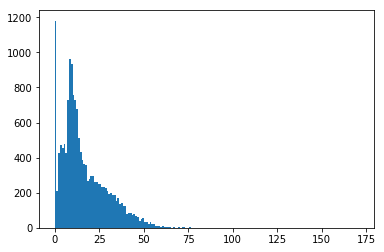

In [24]:
plt.hist(sentenceLengths, bins=170)

## Task 3 - Generate input for the BERT model

Because BERT has a limit of 512 tokens per input, I will try to split documents up into the component sentences, using the max sentence length of 50-75 for training. As can be seen by the histogram above, almost all sentences will fall into this range.

Additionally, for each sentence we will need to add [CLS] and [PAD] tokens

Will need **Sentences, NER Tokens,** and **entity ids**

In [25]:
def createBertTextObjects(text_dict, nerTag_dict, entId_dict, max_sentence_length):
    """
    Add [CLS] and [PAD] tokens to text, NER tag, and entity Id data 
    [PAD] tokens are added until max_sentence_length
    returns bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids
    *Concepts borrowed from BERT_NER_v1
    """
    max_sentence_length -= 1 # to account for Python's zero-based indexing
    
    bert_sentences = []
    bert_ner_tags = []
    bert_entities = []
    bert_mask_ids = []
    
    # start with [CLS] token
    sentence = ['[CLS]'] 
    ner_tags = ['[nerCLS]']
    entity_ids = [0] # magic value for entity CLS #['[entCLS]']
    
    for item in text_dict:
    
        for i in range(len(text_dict[item])):

            if text_dict[item][i] == '[SEP]':
                sentence_length = min(max_sentence_length, len(sentence))

                # truncate sequences that are longer than the max_sentence_length
                sentence = sentence[:max_sentence_length-1]
                ner_tags = ner_tags[:max_sentence_length-1]
                entity_ids = entity_ids[:max_sentence_length-1]

                # mask all [PAD] items
                bert_mask_ids.append([1] * (sentence_length + 1) + 
                                     [0] * (max_sentence_length - sentence_length))

                # insert final [SEP] and [PAD] tokens
                sentence += [text_dict[item][i]] + ['[PAD]'] * (max_sentence_length - len(sentence))
                ner_tags += [nerTag_dict[item][i]] + ['[nerPAD]'] * (max_sentence_length - len(ner_tags))
                entity_ids += [entId_dict[item][i]] + [-3] * (max_sentence_length - len(entity_ids))
                # magic value for entity padding #['[entPAD]']

                bert_sentences.append(sentence)
                bert_ner_tags.append(ner_tags)
                bert_entities.append(entity_ids)

                # restart with [CLS] token
                sentence = ['[CLS]'] 
                ner_tags = ['[nerCLS]']
                entity_ids = [0] # magic value for entity CLS #['[entCLS]']
            else:    
                sentence += [text_dict[item][i]]
                ner_tags += [nerTag_dict[item][i]]
                entity_ids += [entId_dict[item][i]]
            
    bert_mask_ids = np.asarray(bert_mask_ids)
            
    return bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids
        

In [87]:
max_sentence_length = 50

bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids = createBertTextObjects(train_text_dict,
                                                                       train_nerTag_dict,
                                                                       train_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

val_sentences, val_ner_tags, val_entities, val_mask_ids = createBertTextObjects(val_text_dict,
                                                                       val_nerTag_dict,
                                                                       val_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

test_sentences, test_ner_tags, test_entities, test_mask_ids = createBertTextObjects(test_text_dict,
                                                                       test_nerTag_dict,
                                                                       test_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

Now we have our BERT inputs as text, we need to modify all inputs to be numerical values

Approach 1 - NER tags as categorical codes

In [147]:
def createBertNumObjects1(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to categorical codes
    nerTag_categories = pd.DataFrame(np.array(bert_ner_tags).reshape(-1))
    nerTag_categories.columns = ['text']
    nerTag_categories.text = pd.Categorical(nerTag_categories.text)
    nerTag_categories['cat'] = nerTag_categories.text.cat.codes
    nerTag_categories['sym'] = nerTag_categories.cat 
    
    nerDistribution = (nerTag_categories.groupby(['text','cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))
    #print(nerDistribution)
    
    bert_nerTag_ids = np.array(nerTag_categories.cat, dtype=np.int32).reshape(len(bert_ner_tags), len(bert_ner_tags[0]))
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

Approach 2 - Binary tags (i.e. is entity or is not entity)

In [137]:
def createBertNumObjects2(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to binary 'is-entity' boolean
    bert_nerTag_ids = []
    for item in bert_ner_tags:
        sentenceTags = []
        for tag in item:
            if tag in ['B','I']: # i.e. tag corresponds with an entity
                sentenceTags.append([1])
            else:
                sentenceTags.append([0])
        bert_nerTag_ids.append(sentenceTags)
    
    bert_nerTag_ids = np.asarray(bert_nerTag_ids)
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

Approach 3 - codes for only relevant tags

In [276]:
def createBertNumObjects3(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to binary 'is-entity' boolean
    bert_nerTag_ids = []
    for item in bert_ner_tags:
        sentenceTags = []
        for tag in item:
            if tag == 'B': # i.e. tag corresponds with an entity
                sentenceTags.append([1])
            elif tag == 'I':
                sentenceTags.append([2])
            else:
                sentenceTags.append([0])
        bert_nerTag_ids.append(sentenceTags)
    
    bert_nerTag_ids = np.asarray(bert_nerTag_ids)
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

In [277]:
bert_sentence_ids, bert_nerTag_ids, bert_seq_ids = createBertNumObjects3(bert_sentences, bert_ner_tags)

val_sentence_ids, val_nerTag_ids, val_seq_ids = createBertNumObjects3(val_sentences, val_ner_tags)

test_sentence_ids, test_nerTag_ids, test_seq_ids = createBertNumObjects3(test_sentences, test_ner_tags)

In [278]:
print(bert_sentence_ids.shape)
print(bert_nerTag_ids.shape) # extra dim of 1 for labels
print(bert_seq_ids.shape)

(16108, 50)
(16108, 50, 1)
(16108, 50)


## Task 4 - Create entity embeddings for Wikipedia entities

### This will help the task of Candidate Generation for the model

Using the wikiName_id_map_dict created earlier, scrape wikipedia articles for text descriptions of the entity

In [295]:
import wikipedia

In [300]:
print(wikipedia.WikipediaPage(title = 'Brussels').summary[:512])

Brussels (French: Bruxelles [bʁysɛl] (listen) or [bʁyksɛl]; Dutch: Brussel [ˈbrʏsəl] (listen)), officially the Brussels-Capital Region (French: Région de Bruxelles-Capitale; Dutch: Brussels Hoofdstedelijk Gewest), is a region of Belgium comprising 19 municipalities, including the City of Brussels, which is the capital of Belgium. The Brussels-Capital Region is located in the central portion of the country and is a part of both the French Community of Belgium and the Flemish Community, but is separate from t


In [301]:
import time

start_time = time.time()

wikiId_summaryTokens_dict = {}
i = 0
for wikiId in wikiName_id_map_dict:

    if i > 100:
        break # control
    i += 1
    try:
        summary = wikipedia.summary(wikiName_id_map_dict[wikiId])
    except:
        summary = None
        
    if summary:
        dict_value = tokenizer.tokenize(summary)[:512] # max_length
        dict_value = tokenizer.convert_tokens_to_ids(dict_value)
        wikiId_summaryTokens_dict.update({wikiId: dict_value})

timing = time.time() - start_time
print('100 Wikipedia page summaries executed in',round(timing,2),'seconds')

C:\Users\andre\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\andre\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Executed in 174.26 seconds


Given that the summary extraction takes so long, I'm going to cheat a bit to encode the entities as BERT 768 dimensional pooled vectors

In [561]:
entities = []

for item in train_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
for item in validation_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities    
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
for item in test_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
entities = list(set(entities)) # unique entities only

# replace unicode characters
for i in range(len(entities)):
    if '\\u' in entities[i]:
        entities[i] = entities[i].encode().decode('unicode_escape')

In [562]:
entities[:20]

['New_Zealand_national_cricket_team',
 'Tayfun_Korkut',
 'Anthony_Quayle',
 'Parana',
 'Kofi Annan',
 'Huddersfield',
 'Monterey,_California',
 'Lupu',
 'Stagecoach_Group',
 'Norifumi Abe',
 'Jesper Parnevik',
 'Jarmo_Kytölehto',
 'Kazuyoshi Miura',
 'Bengali',
 'Jorge Cadete',
 'Bayern Munich',
 'International Business Machines Corp.',
 'Walter Mondale',
 'TAMPA BAY',
 'Hapoel Ironi']

Now let's add some noise to our entities

In [607]:
entities_ext = []
start_time = time.time()
i = 1

for entity in entities:
    ent_start_time = time.time()
    print(entity, ' - ', str(round((i/len(entities)*100),3))+'%')
    entities_ext.extend(wikipedia.search(entity,results=5))
    timing = time.time() - ent_start_time
    print('\t', round(timing,2),'seconds')
    i += 1

timing = time.time() - start_time

print('\n\n')
print('Created noise for',len(entities),'entities. Executed in', round((timing/60),2),'minutes')

New_Zealand_national_cricket_team  -  0.008%
	 0.0 seconds
Tayfun_Korkut  -  0.017%
	 0.0 seconds
Anthony_Quayle  -  0.025%
	 0.0 seconds
Parana  -  0.034%
	 0.0 seconds
Kofi Annan  -  0.042%
	 0.0 seconds
Huddersfield  -  0.051%
	 0.0 seconds
Monterey,_California  -  0.059%
	 0.0 seconds
Lupu  -  0.068%
	 0.0 seconds
Stagecoach_Group  -  0.076%
	 0.0 seconds
Norifumi Abe  -  0.085%
	 0.0 seconds
Jesper Parnevik  -  0.093%
	 0.0 seconds
Jarmo_Kytölehto  -  0.102%
	 0.0 seconds
Kazuyoshi Miura  -  0.11%
	 0.0 seconds
Bengali  -  0.119%
	 0.0 seconds
Jorge Cadete  -  0.127%
	 0.0 seconds
Bayern Munich  -  0.136%
	 0.0 seconds
International Business Machines Corp.  -  0.144%
	 0.0 seconds
Walter Mondale  -  0.153%
	 0.01 seconds
TAMPA BAY  -  0.161%
	 0.0 seconds
Hapoel Ironi  -  0.17%
	 0.0 seconds
Trenidad_Hubbard  -  0.178%
	 0.0 seconds
wall Street  -  0.187%
	 0.0 seconds
Redgrave  -  0.195%
	 0.0 seconds
DBRS  -  0.204%
	 0.0 seconds
Oslobođenje  -  0.212%
	 0.0 seconds
Anthony Wash

	 0.0 seconds
Pavel_Muslimov  -  3.013%
	 0.0 seconds
Minnesota  -  3.022%
	 0.0 seconds
Brown Deer Park Golf Course  -  3.03%
	 0.0 seconds
East  -  3.039%
	 0.0 seconds
Alex Fernandez  -  3.047%
	 0.0 seconds
José_Ramos-Horta  -  3.056%
	 0.0 seconds
Security_Council_of_Russia  -  3.064%
	 0.0 seconds
Remington  -  3.072%
	 0.0 seconds
Noriaki_Kasai  -  3.081%
	 0.0 seconds
New_York_Mercantile_Exchange  -  3.089%
	 0.0 seconds
Gatwick  -  3.098%
	 0.01 seconds
As-Safir  -  3.106%
	 0.0 seconds
Lisa_Raymond  -  3.115%
	 0.0 seconds
Mike_Tyson  -  3.123%
	 0.0 seconds
Marina_Trandenkova  -  3.132%
	 0.0 seconds
Shiraz  -  3.14%
	 0.0 seconds
Giovanni_Lavaggi  -  3.149%
	 0.0 seconds
Le_Temps  -  3.157%
	 0.0 seconds
Jose Coceres  -  3.166%
	 0.0 seconds
SCOTLAND  -  3.174%
	 0.0 seconds
Constantin Galca  -  3.183%
	 0.0 seconds
Ray Lankford  -  3.191%
	 0.0 seconds
Johns_Hopkins_Hospital  -  3.2%
	 0.0 seconds
ZAANDAM  -  3.208%
	 0.0 seconds
Alexandre Gontchenkov  -  3.217%
	 0.0 seco

Marc Overmars  -  5.542%
	 0.0 seconds
Bosnia  -  5.551%
	 0.0 seconds
Kent  -  5.559%
	 0.0 seconds
BISTRITA  -  5.568%
	 0.0 seconds
Kubilay_Türkyilmaz  -  5.576%
	 0.0 seconds
Croatian  -  5.585%
	 0.0 seconds
WBO  -  5.593%
	 0.0 seconds
Afrikaner  -  5.602%
	 0.0 seconds
MAPUTO  -  5.61%
	 0.0 seconds
Mustapha_Hadji  -  5.619%
	 0.0 seconds
Cruzeiro_Esporte_Clube  -  5.627%
	 0.0 seconds
Lima  -  5.636%
	 0.0 seconds
Regina Jacobs  -  5.644%
	 0.01 seconds
Yeosu  -  5.653%
	 0.0 seconds
Alain Juppe  -  5.661%
	 0.0 seconds
London Irish  -  5.67%
	 0.0 seconds
Lucy_Tyler-Sharman  -  5.678%
	 0.0 seconds
Billie Jean King  -  5.687%
	 0.0 seconds
Columbia Presbyterian Hospital  -  5.695%
	 0.0 seconds
Inger_Miller  -  5.704%
	 0.0 seconds
Arrigo_Sacchi  -  5.712%
	 0.0 seconds
Zhejiang  -  5.721%
	 0.0 seconds
Toyota Australia  -  5.729%
	 0.0 seconds
Katja_Seizinger  -  5.738%
	 0.0 seconds
Kwasniewski  -  5.746%
	 0.0 seconds
Ken_Saro-Wiwa  -  5.755%
	 0.0 seconds
Wasim  -  5.763%


Jeff_Tarango  -  8.089%
	 0.0 seconds
Missionaries_of_Charity  -  8.097%
	 0.0 seconds
Rocky_Coppinger  -  8.106%
	 0.0 seconds
Agent_Orange  -  8.114%
	 0.0 seconds
VTM  -  8.123%
	 0.0 seconds
Iltalehti  -  8.131%
	 0.0 seconds
Ruutel  -  8.14%
	 0.0 seconds
Confederation_of_British_Industry  -  8.148%
	 0.0 seconds
NL East  -  8.157%
	 0.0 seconds
Shimon_Peres  -  8.165%
	 0.0 seconds
World Series  -  8.173%
	 0.0 seconds
Ulysses_S._Grant  -  8.182%
	 0.0 seconds
REAL  -  8.19%
	 0.0 seconds
Marc_Wilkins_(baseball)  -  8.199%
	 0.0 seconds
Gyor  -  8.207%
	 0.01 seconds
Polti  -  8.216%
	 0.0 seconds
Michael_Möllenbeck  -  8.224%
	 0.0 seconds
Resalat_(newspaper)  -  8.233%
	 0.0 seconds
Pembroke Pines  -  8.241%
	 0.0 seconds
Estonia_national_football_team  -  8.25%
	 0.0 seconds
South_Kivu  -  8.258%
	 0.0 seconds
Francisco Palencia  -  8.267%
	 0.0 seconds
Pedro_Lamy  -  8.275%
	 0.0 seconds
Coalition_(Australia)  -  8.284%
	 0.0 seconds
Randall  -  8.292%
	 0.0 seconds
Kindu  - 

	 0.0 seconds
Collingwood  -  10.788%
	 0.0 seconds
Siam_Commercial_Bank  -  10.796%
	 0.0 seconds
Stewart Ginn  -  10.805%
	 0.0 seconds
APPLETON  -  10.813%
	 0.0 seconds
Jimi Hendrix  -  10.822%
	 0.0 seconds
Winston_Peters  -  10.83%
	 0.0 seconds
Russ Berrie  -  10.839%
	 0.0 seconds
Roda JC  -  10.847%
	 0.0 seconds
Dana_Rohrabacher  -  10.856%
	 0.0 seconds
PSI Net  -  10.864%
	 0.0 seconds
Naoki_Soma  -  10.873%
	 0.0 seconds
Faustino_Asprilla  -  10.881%
	 0.0 seconds
Sarka Kasparkova  -  10.889%
	 0.0 seconds
ASIA  -  10.898%
	 0.0 seconds
Patrice Loko  -  10.906%
	 0.0 seconds
Espen Bredesen  -  10.915%
	 0.0 seconds
Liberal  -  10.923%
	 0.0 seconds
Viva_Zapata!  -  10.932%
	 0.0 seconds
Venezuela  -  10.94%
	 0.0 seconds
Kapil_Dev  -  10.949%
	 0.0 seconds
John_Howard  -  10.957%
	 0.0 seconds
Chiquinho_Conde  -  10.966%
	 0.0 seconds
Atlante_F.C.  -  10.974%
	 0.0 seconds
Snyman  -  10.983%
	 0.0 seconds
Phil Babb  -  10.991%
	 0.0 seconds
Panionios  -  11.0%
	 0.0 second

Guillaume_Raoux  -  13.249%
	 0.01 seconds
Garhi Habibullah  -  13.258%
	 0.0 seconds
Florida_Panthers  -  13.266%
	 0.0 seconds
CTBT  -  13.274%
	 0.0 seconds
Michael_Doohan  -  13.283%
	 0.0 seconds
Barry_Bonds  -  13.291%
	 0.0 seconds
Catholic  -  13.3%
	 0.0 seconds
Swansea_City_A.F.C.  -  13.308%
	 0.0 seconds
Nathalie Tauziat  -  13.317%
	 0.0 seconds
Oliver Kahn  -  13.325%
	 0.0 seconds
Andrea Gaudenzi  -  13.334%
	 0.0 seconds
Democratic  -  13.342%
	 0.0 seconds
Zaragoza  -  13.351%
	 0.0 seconds
U.S. Open  -  13.359%
	 0.0 seconds
Karsten Baeron  -  13.368%
	 0.0 seconds
Jayasuriya  -  13.376%
	 0.0 seconds
Ajax Amsterdam  -  13.385%
	 0.0 seconds
Dennis Lillee  -  13.393%
	 0.0 seconds
Nawaz Sharif  -  13.402%
	 0.0 seconds
Mauro_Silva  -  13.41%
	 0.0 seconds
NOVYE ATAGI  -  13.419%
	 0.0 seconds
A_Coruña  -  13.427%
	 0.0 seconds
Clarksburg  -  13.436%
	 0.0 seconds
Christian  -  13.444%
	 0.0 seconds
Volker Ruehe  -  13.453%
	 0.0 seconds
James_Brady  -  13.461%
	 0.0 s

	 0.0 seconds
Miami Dolphins  -  15.626%
	 0.0 seconds
Metro_AG  -  15.634%
	 0.0 seconds
Nicaragua  -  15.643%
	 0.0 seconds
Scottish National Party  -  15.651%
	 0.0 seconds
Ross_McFarlane  -  15.659%
	 0.0 seconds
Whistler_Mountain  -  15.668%
	 0.0 seconds
MARCELO  -  15.676%
	 0.0 seconds
Chuck_Adams  -  15.685%
	 0.0 seconds
FC_Baník_Ostrava  -  15.693%
	 0.0 seconds
Aqaba  -  15.702%
	 0.0 seconds
Minnesota Twins  -  15.71%
	 0.0 seconds
North Yemen  -  15.719%
	 0.0 seconds
Bnei_Yehuda_Tel_Aviv_F.C.  -  15.727%
	 0.0 seconds
CARACAS  -  15.736%
	 0.0 seconds
HAVEL  -  15.744%
	 0.0 seconds
Manuel_Medina_(boxer)  -  15.753%
	 0.0 seconds
Bertelsmann AG  -  15.761%
	 0.0 seconds
Alexander_Popov_(swimmer)  -  15.77%
	 0.0 seconds
Montreal  -  15.778%
	 0.0 seconds
Charles_Taylor_(Liberia)  -  15.787%
	 0.0 seconds
Tim Simpson  -  15.795%
	 0.0 seconds
Eric Bergoust  -  15.804%
	 0.0 seconds
Allenby Bridge  -  15.812%
	 0.0 seconds
Azerbaijan  -  15.821%
	 0.0 seconds
National_Leag

	 0.0 seconds
Eritrean  -  18.095%
	 0.0 seconds
EUROPEAN  -  18.104%
	 0.0 seconds
Mehrtens  -  18.112%
	 0.0 seconds
Andhra_Pradesh  -  18.121%
	 0.0 seconds
SUPERCUP  -  18.129%
	 0.0 seconds
Electronic Data Systems  -  18.138%
	 0.0 seconds
Steve Howey  -  18.146%
	 0.0 seconds
Bill_Clinton  -  18.155%
	 0.0 seconds
WSC_World_XI  -  18.163%
	 0.0 seconds
Edward_Said  -  18.172%
	 0.0 seconds
Michael_Joyce_(tennis)  -  18.18%
	 0.0 seconds
TSV_1860_München  -  18.189%
	 0.0 seconds
Hassan_II_of_Morocco  -  18.197%
	 0.0 seconds
Wang_Chen_(badminton)  -  18.206%
	 0.0 seconds
Blackpool_F.C.  -  18.214%
	 0.0 seconds
Jamie_Moyer  -  18.223%
	 0.0 seconds
Inspector Maigret  -  18.231%
	 0.0 seconds
Nolan Ryan  -  18.24%
	 0.0 seconds
Derrick_Cooper  -  18.248%
	 0.0 seconds
Maurice_Graef  -  18.257%
	 0.0 seconds
Franz_Fischler  -  18.265%
	 0.0 seconds
Mexico_City  -  18.274%
	 0.0 seconds
Ireland_national_rugby_union_team  -  18.282%
	 0.0 seconds
Rennae_Stubbs  -  18.291%
	 0.0 seco

Karachi_Stock_Exchange  -  20.811%
	 0.0 seconds
Gianluca Pozzi  -  20.82%
	 0.0 seconds
Nyva Ternopil  -  20.828%
	 0.0 seconds
Sulaymaniyah  -  20.837%
	 0.0 seconds
GROBBELAAR  -  20.845%
	 0.0 seconds
Cabinet  -  20.854%
	 0.0 seconds
Crvena zvezda  -  20.862%
	 0.0 seconds
Kitty Kiernan  -  20.871%
	 0.0 seconds
Gulf of Mexico  -  20.879%
	 0.0 seconds
Fulham_F.C.  -  20.888%
	 0.0 seconds
Andre Trulsen  -  20.896%
	 0.0 seconds
Inchon  -  20.905%
	 0.0 seconds
Stefan_Johansson  -  20.913%
	 0.0 seconds
K.A.A._Gent  -  20.922%
	 0.0 seconds
Didier_Deschamps  -  20.93%
	 0.0 seconds
Peter_Tramacchi  -  20.939%
	 0.0 seconds
Leah_Pells  -  20.947%
	 0.0 seconds
Japie Mulder  -  20.956%
	 0.0 seconds
Brighton  -  20.964%
	 0.0 seconds
Hereford  -  20.973%
	 0.0 seconds
Alexei Markov  -  20.981%
	 0.02 seconds
FORMULA SHELL  -  20.99%
	 0.0 seconds
Dunnes Stores  -  20.998%
	 0.0 seconds
Upul Chandana  -  21.007%
	 0.0 seconds
Zagreb  -  21.015%
	 0.0 seconds
Viktor Chernomyrdin  -  2

Miguel Angel Jimenez  -  23.383%
	 0.0 seconds
Andre_Snyman  -  23.392%
	 0.0 seconds
Driller  -  23.4%
	 0.0 seconds
Andrea Glass  -  23.409%
	 0.0 seconds
AJ_Auxerre  -  23.417%
	 0.0 seconds
Mark_Dekker  -  23.426%
	 0.0 seconds
Middle East Economic Survey  -  23.434%
	 0.0 seconds
Nazi_Germany  -  23.443%
	 0.0 seconds
British Airways  -  23.451%
	 0.0 seconds
Tom Johnson  -  23.46%
	 0.0 seconds
DAMASCUS  -  23.468%
	 0.0 seconds
Republika_Srpska  -  23.476%
	 0.0 seconds
Sun_Jun_(badminton)  -  23.485%
	 0.0 seconds
Hamlet Cup  -  23.493%
	 0.0 seconds
MEDVEDEV  -  23.502%
	 0.0 seconds
Miss Universe  -  23.51%
	 0.0 seconds
David Batty  -  23.519%
	 0.0 seconds
Communist_party  -  23.527%
	 0.0 seconds
Napoleon III  -  23.536%
	 0.0 seconds
Hingis  -  23.544%
	 0.0 seconds
Stansted_Mountfitchet  -  23.553%
	 0.01 seconds
Billy_Ashley  -  23.561%
	 0.0 seconds
Vancouver Canucks  -  23.57%
	 0.0 seconds
Don_Wengert  -  23.578%
	 0.0 seconds
Nolan_Ryan  -  23.587%
	 0.0 seconds
Den

	 0.0 seconds
Soviet_Union  -  25.828%
	 0.0 seconds
Svetlana Masterkova  -  25.836%
	 0.0 seconds
Roberto_Durán  -  25.845%
	 0.0 seconds
Pat Hentgen  -  25.853%
	 0.0 seconds
Miami Herald  -  25.861%
	 0.0 seconds
Bury_F.C.  -  25.87%
	 0.0 seconds
Buddy_Groom  -  25.878%
	 0.0 seconds
Chicago_Mercantile_Exchange  -  25.887%
	 0.0 seconds
Chanda_Rubin  -  25.895%
	 0.0 seconds
Parnevik  -  25.904%
	 0.0 seconds
Steve Brown  -  25.912%
	 0.0 seconds
Viorel Ion  -  25.921%
	 0.01 seconds
Insein Prison  -  25.929%
	 0.0 seconds
Hicham_Arazi  -  25.938%
	 0.0 seconds
Hungarian  -  25.946%
	 0.0 seconds
Mark_Davis_(golfer)  -  25.955%
	 0.0 seconds
Houston_Astros  -  25.963%
	 0.0 seconds
CSP_Limoges  -  25.972%
	 0.0 seconds
New_South_Wales_rugby_league_team  -  25.98%
	 0.0 seconds
Chavakachcheri  -  25.989%
	 0.0 seconds
Hawaii  -  25.997%
	 0.0 seconds
Buenos_Aires_Province  -  26.006%
	 0.0 seconds
Mark_Chaloner  -  26.014%
	 0.0 seconds
L-Orizzont  -  26.023%
	 0.0 seconds
Boutros B

Camden  -  28.357%
	 0.0 seconds
Gazzetta dello Sport  -  28.365%
	 0.0 seconds
Fremantle  -  28.374%
	 0.0 seconds
Hooper  -  28.382%
	 0.0 seconds
JERUSALEM POST  -  28.391%
	 0.0 seconds
Post  -  28.399%
	 0.0 seconds
Deborah_Compagnoni  -  28.408%
	 0.0 seconds
Northerns_cricket_team  -  28.416%
	 0.0 seconds
Bernama  -  28.425%
	 0.0 seconds
Perry  -  28.433%
	 0.0 seconds
Crawley  -  28.442%
	 0.0 seconds
Troy  -  28.45%
	 0.0 seconds
Godee  -  28.459%
	 0.0 seconds
Jimmy_Vasser  -  28.467%
	 0.0 seconds
Aleksandra_Olsza  -  28.476%
	 0.0 seconds
Mike_Harwood  -  28.484%
	 0.0 seconds
Racing_de_Santander  -  28.493%
	 0.0 seconds
Tony_Underwood  -  28.501%
	 0.0 seconds
Toomas Savi  -  28.51%
	 0.0 seconds
Simone Greiner-Petter-Memm  -  28.518%
	 0.0 seconds
Kenny_Lofton  -  28.527%
	 0.0 seconds
Boland  -  28.535%
	 0.0 seconds
Islamism  -  28.544%
	 0.0 seconds
SK_Sigma_Olomouc  -  28.552%
	 0.0 seconds
Duncan Ferguson  -  28.561%
	 0.0 seconds
Husqvarna_Motorcycles  -  28.569%

Petre Roman  -  30.971%
	 0.0 seconds
Mustapha Hadji  -  30.979%
	 0.0 seconds
Alan Kernaghan  -  30.988%
	 0.0 seconds
Ata-ur-Rehman  -  30.996%
	 0.0 seconds
Resistance_movement  -  31.005%
	 0.0 seconds
PDS  -  31.013%
	 0.0 seconds
A.S._Roma  -  31.022%
	 0.0 seconds
Montreal_Expos  -  31.03%
	 0.0 seconds
Itar-Tass  -  31.039%
	 0.0 seconds
Christian_Blanc  -  31.047%
	 0.0 seconds
André_Joubert  -  31.056%
	 0.0 seconds
Dickson  -  31.064%
	 0.0 seconds
Butch  -  31.073%
	 0.0 seconds
Theodoros Pangalos  -  31.081%
	 0.0 seconds
San_Marino_national_football_team  -  31.09%
	 0.0 seconds
Polonia Warsaw  -  31.098%
	 0.0 seconds
Ghana  -  31.107%
	 0.0 seconds
Bremen_Airport  -  31.115%
	 0.0 seconds
Slovakia  -  31.124%
	 0.0 seconds
Russians  -  31.132%
	 0.0 seconds
Meghann_Shaughnessy  -  31.141%
	 0.0 seconds
Sierra_Leone  -  31.149%
	 0.0 seconds
Udinese  -  31.158%
	 0.0 seconds
Gabriela Sabatini  -  31.166%
	 0.0 seconds
Paris SG  -  31.175%
	 0.0 seconds
GRAND SLAM CUP  - 

	 0.0 seconds
Bangkok  -  34.01%
	 0.0 seconds
Tomás_Carbonell  -  34.018%
	 0.0 seconds
São_Paulo_(state)  -  34.026%
	 0.0 seconds
Murphy Jensen  -  34.035%
	 0.0 seconds
Breisach  -  34.043%
	 0.0 seconds
Noriyuki Haga  -  34.052%
	 0.0 seconds
Alexander_Gontchenkov  -  34.06%
	 0.0 seconds
Topoľčany  -  34.069%
	 0.0 seconds
Ian Harte  -  34.077%
	 0.0 seconds
Olivier Panis  -  34.086%
	 0.0 seconds
Commerce Department  -  34.094%
	 0.0 seconds
Masayuki_Okano  -  34.103%
	 0.0 seconds
Ian_Wright  -  34.111%
	 0.0 seconds
Nasdaq  -  34.12%
	 0.0 seconds
Durres  -  34.128%
	 0.0 seconds
Derek Crookes  -  34.137%
	 0.0 seconds
Annett Neumann  -  34.145%
	 0.0 seconds
Arlington,_Texas  -  34.154%
	 0.0 seconds
Guatemala  -  34.162%
	 0.0 seconds
Georgios_Panagiotopoulos  -  34.171%
	 0.0 seconds
Michael_Jonzon  -  34.179%
	 0.0 seconds
Edberg  -  34.188%
	 0.0 seconds
North_Melbourne_Football_Club  -  34.196%
	 0.0 seconds
British Jewish  -  34.205%
	 0.0 seconds
Jacky_Martens  -  34.2

Sierra_Leone_national_football_team  -  36.42%
	 0.0 seconds
Viljoen  -  36.428%
	 0.0 seconds
Manly-Warringah_Sea_Eagles  -  36.437%
	 0.0 seconds
Andrea Collinelli  -  36.445%
	 0.0 seconds
Neil_Back  -  36.454%
	 0.0 seconds
Tommy_Thompson  -  36.462%
	 0.0 seconds
Johan_de_Kock  -  36.471%
	 0.0 seconds
FK_Viktoria_Žižkov  -  36.479%
	 0.0 seconds
Uruguayan  -  36.488%
	 0.0 seconds
Mike Harwood  -  36.496%
	 0.0 seconds
National Football League  -  36.505%
	 0.0 seconds
Howard_Wilkinson  -  36.513%
	 0.01 seconds
Lens  -  36.522%
	 0.0 seconds
Marie Lindgren  -  36.53%
	 0.0 seconds
CNBC  -  36.539%
	 0.0 seconds
Carl  -  36.547%
	 0.0 seconds
Fulham  -  36.556%
	 0.0 seconds
Tom Candiotti  -  36.564%
	 0.0 seconds
Anthony_Raine_Barker  -  36.573%
	 0.0 seconds
Kristian Brenden  -  36.581%
	 0.0 seconds
Eddo_Brandes  -  36.59%
	 0.0 seconds
Taiwan_Strait  -  36.598%
	 0.0 seconds
Brad_Ausmus  -  36.607%
	 0.0 seconds
Malawi  -  36.615%
	 0.01 seconds
New York Yankees  -  36.624%
	

Fortuna Duesseldorf  -  39.297%
	 0.0 seconds
New_Zealand_Labour_Party  -  39.306%
	 0.0 seconds
Pontefract  -  39.314%
	 0.0 seconds
Edgar Martinez  -  39.323%
	 0.0 seconds
USTA_Billie_Jean_King_National_Tennis_Center  -  39.331%
	 0.0 seconds
Jens_Fiedler_(cyclist)  -  39.34%
	 0.0 seconds
Dohuk  -  39.348%
	 0.0 seconds
MEHRTENS  -  39.357%
	 0.0 seconds
Calcutta  -  39.365%
	 0.0 seconds
Madrid  -  39.374%
	 0.0 seconds
Ray Houghton  -  39.382%
	 0.0 seconds
Washington, D.C.  -  39.391%
	 0.0 seconds
Chester-le-Street  -  39.399%
	 0.0 seconds
Gareth Farrelly  -  39.408%
	 0.0 seconds
Orlando_Pace  -  39.416%
	 0.0 seconds
Worcestershire_County_Cricket_Club  -  39.425%
	 0.0 seconds
Stuart Law  -  39.433%
	 0.0 seconds
Bradford Vaughan  -  39.442%
	 0.0 seconds
St Louis  -  39.45%
	 0.0 seconds
Thompson  -  39.458%
	 0.0 seconds
Gabriela_Szabo  -  39.467%
	 0.01 seconds
Banfield  -  39.475%
	 0.0 seconds
Oxford_United_F.C.  -  39.484%
	 0.0 seconds
Mark_Ealham  -  39.492%
	 0.0 se

	 0.0 seconds
PORT LOUIS  -  41.869%
	 0.0 seconds
Patrick_Sylvestre  -  41.877%
	 0.0 seconds
Aziz  -  41.886%
	 0.0 seconds
Kobus_Wiese  -  41.894%
	 0.0 seconds
Aliuska_López  -  41.903%
	 0.0 seconds
Massoud_Barzani  -  41.911%
	 0.0 seconds
Washington_Redskins  -  41.92%
	 0.0 seconds
Rad  -  41.928%
	 0.0 seconds
Botafogo_de_Futebol_e_Regatas  -  41.937%
	 0.0 seconds
Rodney_Eyles  -  41.945%
	 0.0 seconds
Olo_Brown  -  41.954%
	 0.0 seconds
Masakiyo_Maezono  -  41.962%
	 0.0 seconds
SWEDEN  -  41.971%
	 0.0 seconds
Davis_Love_III  -  41.979%
	 0.0 seconds
Circuit_de_Spa-Francorchamps  -  41.988%
	 0.0 seconds
Portland,_Oregon  -  41.996%
	 0.0 seconds
Seles  -  42.005%
	 0.0 seconds
Yankee  -  42.013%
	 0.0 seconds
New_Zealand  -  42.022%
	 0.0 seconds
Timişoara  -  42.03%
	 0.0 seconds
Pontiac,_Michigan  -  42.039%
	 0.0 seconds
Bournemouth  -  42.047%
	 0.0 seconds
Indian  -  42.056%
	 0.0 seconds
Scarborough  -  42.064%
	 0.0 seconds
Johnson Controls Inc  -  42.073%
	 0.0 sec

	 0.0 seconds
Lloyd_Bentsen  -  44.517%
	 0.0 seconds
SCHUMACHER  -  44.526%
	 0.0 seconds
Gete_Wami  -  44.534%
	 0.0 seconds
North Atlantic Treaty Organisation  -  44.543%
	 0.0 seconds
Ian Healy  -  44.551%
	 0.0 seconds
Matthew_Le_Tissier  -  44.559%
	 0.0 seconds
Chris Woodruff  -  44.568%
	 0.0 seconds
Mats_Wilander  -  44.576%
	 0.0 seconds
Marko Koers  -  44.585%
	 0.0 seconds
Catania  -  44.593%
	 0.0 seconds
Ilott  -  44.602%
	 0.0 seconds
Noureddine_Morceli  -  44.61%
	 0.0 seconds
Kredietbank  -  44.619%
	 0.0 seconds
Irvine,_California  -  44.627%
	 0.0 seconds
Surabaya  -  44.636%
	 0.0 seconds
Antwerp  -  44.644%
	 0.0 seconds
FK_Baumit_Jablonec  -  44.653%
	 0.0 seconds
Udinese_Calcio  -  44.661%
	 0.0 seconds
C. Rangarajan  -  44.67%
	 0.0 seconds
Missouri  -  44.678%
	 0.0 seconds
ABC  -  44.687%
	 0.0 seconds
Sandusky,_Ohio  -  44.695%
	 0.0 seconds
Mike_Williams_(baseball)  -  44.704%
	 0.0 seconds
FC_Aarau  -  44.712%
	 0.0 seconds
Phnom Penh  -  44.721%
	 0.0 seco

	 0.0 seconds
St._Leger_Stakes  -  47.42%
	 0.0 seconds
Marylebone_Cricket_Club  -  47.428%
	 0.0 seconds
Sumitomo  -  47.437%
	 0.0 seconds
Nani Palkhivala  -  47.445%
	 0.0 seconds
Petr Korda  -  47.454%
	 0.0 seconds
Ed_Vosberg  -  47.462%
	 0.0 seconds
Federal_Aviation_Administration  -  47.471%
	 0.0 seconds
Euro-sceptic  -  47.479%
	 0.0 seconds
Gatwick_Airport  -  47.488%
	 0.0 seconds
FC_Twente  -  47.496%
	 0.0 seconds
KANPUR  -  47.505%
	 0.0 seconds
Michael_Slater  -  47.513%
	 0.0 seconds
FC_Nyva_Ternopil  -  47.522%
	 0.0 seconds
Haneda_Airport  -  47.53%
	 0.0 seconds
Balkan Airlines  -  47.539%
	 0.0 seconds
Chicago_White_Sox  -  47.547%
	 0.0 seconds
Jean-Michel_Bayle  -  47.556%
	 0.0 seconds
DAX  -  47.564%
	 0.0 seconds
Guy_Whittingham  -  47.573%
	 0.0 seconds
Mário_Covas  -  47.581%
	 0.0 seconds
Deng_Xiaoping  -  47.59%
	 0.0 seconds
Roberto Ayala  -  47.598%
	 0.0 seconds
Miriam_Oremans  -  47.607%
	 0.0 seconds
Democratic_Karen_Buddhist_Army  -  47.615%
	 0.0 se

Zimbabwe_national_football_team  -  50.229%
	 0.0 seconds
Norodom_Sihanouk  -  50.238%
	 0.0 seconds
Karbacher  -  50.246%
	 0.0 seconds
Rep.  -  50.255%
	 0.0 seconds
Matthias Sammer  -  50.263%
	 0.0 seconds
Craig Quinnell  -  50.272%
	 0.0 seconds
Jim_Harbaugh  -  50.28%
	 0.0 seconds
Michaela Dorfmeister  -  50.289%
	 0.0 seconds
Giovanni_Silva_de_Oliveira  -  50.297%
	 0.0 seconds
Zycie Warszawy  -  50.306%
	 0.0 seconds
BNP  -  50.314%
	 0.0 seconds
Brett_Martin  -  50.323%
	 0.0 seconds
Marius_Hurter  -  50.331%
	 0.0 seconds
Daniel Vacek  -  50.34%
	 0.0 seconds
NASDAQ  -  50.348%
	 0.0 seconds
Husaberg  -  50.356%
	 0.0 seconds
Heineken_Pilsener  -  50.365%
	 0.0 seconds
Stephen McAllister  -  50.373%
	 0.0 seconds
Damien Lynch  -  50.382%
	 0.0 seconds
Camilla Martin  -  50.39%
	 0.0 seconds
Nico Motchebon  -  50.399%
	 0.0 seconds
South Korean  -  50.407%
	 0.0 seconds
Derek_Jeter  -  50.416%
	 0.0 seconds
Francesco_Mazzariol  -  50.424%
	 0.0 seconds
Chihuahua,_Chihuahua  -

	 0.0 seconds
Melbourne Cricket Ground  -  52.809%
	 0.0 seconds
Susi_Susanti  -  52.818%
	 0.0 seconds
DENVER  -  52.826%
	 0.0 seconds
FIORENTINA  -  52.835%
	 0.0 seconds
Melville  -  52.843%
	 0.0 seconds
Mont-sur-Marchienne  -  52.852%
	 0.0 seconds
Gale Norton  -  52.86%
	 0.0 seconds
Joakim_Persson  -  52.869%
	 0.0 seconds
Chrysler_Classic_of_Tucson  -  52.877%
	 0.0 seconds
Begum Khaleda Zia  -  52.886%
	 0.0 seconds
Medellin  -  52.894%
	 0.0 seconds
Paramount_Pictures  -  52.903%
	 0.0 seconds
Rainier_III,_Prince_of_Monaco  -  52.911%
	 0.0 seconds
Stewart_Ginn  -  52.92%
	 0.0 seconds
FTSE  -  52.928%
	 0.0 seconds
Husqvarna  -  52.937%
	 0.0 seconds
Nicole_Brown_Simpson  -  52.945%
	 0.0 seconds
Thomas_Strunz  -  52.954%
	 0.0 seconds
Cincinnati  -  52.962%
	 0.0 seconds
South Korea  -  52.971%
	 0.0 seconds
Television_New_Zealand  -  52.979%
	 0.0 seconds
La_création_du_monde  -  52.988%
	 0.0 seconds
Gloucestershire  -  52.996%
	 0.0 seconds
JAPAN  -  53.005%
	 0.0 secon

	 0.0 seconds
Al Gore  -  55.916%
	 0.0 seconds
Paul Justin  -  55.924%
	 0.0 seconds
Marvin_Benard  -  55.933%
	 0.0 seconds
Fatos_Nano  -  55.941%
	 0.0 seconds
ORIOLES  -  55.95%
	 0.0 seconds
Ramón_Delgado  -  55.958%
	 0.0 seconds
Rupert Murdoch  -  55.967%
	 0.0 seconds
Heinz-Harald_Frentzen  -  55.975%
	 0.0 seconds
Bogdan_Stelea  -  55.984%
	 0.0 seconds
Danny Blind  -  55.992%
	 0.0 seconds
Tavria  -  56.001%
	 0.0 seconds
Movement_of_Socialist_Democrats  -  56.009%
	 0.0 seconds
Las_Vegas,_Nevada  -  56.018%
	 0.0 seconds
Nigel Walker  -  56.026%
	 0.0 seconds
Greg_Gagne_(baseball)  -  56.035%
	 0.0 seconds
AZ_(football_club)  -  56.043%
	 0.0 seconds
Andy_Goram  -  56.052%
	 0.0 seconds
TENDULKAR  -  56.06%
	 0.0 seconds
Ray Knight  -  56.069%
	 0.0 seconds
Alami  -  56.077%
	 0.0 seconds
East North Central  -  56.086%
	 0.01 seconds
Brian_Shimer  -  56.094%
	 0.0 seconds
Silicon_Valley  -  56.103%
	 0.0 seconds
Gough  -  56.111%
	 0.0 seconds
Wolfgang Feiersinger  -  56.12%

	 0.0 seconds
Emiliano Mondonico  -  58.437%
	 0.0 seconds
West Bengal  -  58.445%
	 0.0 seconds
Abdalá_Bucaram  -  58.454%
	 0.0 seconds
East_Java  -  58.462%
	 0.0 seconds
Colorado_Rockies  -  58.471%
	 0.0 seconds
DWYER  -  58.479%
	 0.0 seconds
Krasnoyarsk_Krai  -  58.488%
	 0.0 seconds
Kenya  -  58.496%
	 0.0 seconds
Gregor_Townsend  -  58.504%
	 0.0 seconds
Mats Lanner  -  58.513%
	 0.0 seconds
South Carolina  -  58.521%
	 0.0 seconds
EYLES  -  58.53%
	 0.0 seconds
Reading  -  58.538%
	 0.0 seconds
Pan_American_World_Airways  -  58.547%
	 0.0 seconds
Islamic Republic of Iran  -  58.555%
	 0.0 seconds
Filippo_Inzaghi  -  58.564%
	 0.0 seconds
Rob_Howley  -  58.572%
	 0.0 seconds
Dalmatians  -  58.581%
	 0.0 seconds
Franka Dietzsch  -  58.589%
	 0.0 seconds
Tim Horan  -  58.598%
	 0.0 seconds
Ivanov  -  58.606%
	 0.0 seconds
Leah Pells  -  58.615%
	 0.0 seconds
Anne-Gaëlle_Sidot  -  58.623%
	 0.0 seconds
Rennae Stubbs  -  58.632%
	 0.0 seconds
Ajay Jadeja  -  58.64%
	 0.0 seconds
B

Monica Seles  -  61.093%
	 0.01 seconds
Lloyd Bentsen  -  61.102%
	 0.0 seconds
Costis Stephanopoulos  -  61.11%
	 0.0 seconds
Subaru  -  61.119%
	 0.0 seconds
United_States_Department_of_State  -  61.127%
	 0.0 seconds
Hussein_of_Jordan  -  61.136%
	 0.0 seconds
Joseph_Stalin  -  61.144%
	 0.0 seconds
African_American  -  61.153%
	 0.0 seconds
Haruchika  -  61.161%
	 0.0 seconds
Ole_Gunnar_Solskjær  -  61.17%
	 0.0 seconds
Menlo_Park,_California  -  61.178%
	 0.0 seconds
HALO_Trust  -  61.187%
	 0.01 seconds
R._Nicholas_Burns  -  61.195%
	 0.0 seconds
North_West_(South_African_province)  -  61.204%
	 0.0 seconds
John McNamara  -  61.212%
	 0.0 seconds
Kevin Tapani  -  61.221%
	 0.0 seconds
Reserve Bank of Australia  -  61.229%
	 0.0 seconds
John_J._Sheehan  -  61.237%
	 0.0 seconds
Liviu_Ciobotariu  -  61.246%
	 0.0 seconds
Dow  -  61.254%
	 0.0 seconds
Party of Democratic Action  -  61.263%
	 0.0 seconds
Rochester  -  61.271%
	 0.0 seconds
UEFA Cup  -  61.28%
	 0.0 seconds
Wisla Krak

Saddam Hussein  -  62.952%
	 0.0 seconds
Nordegg  -  62.96%
	 0.0 seconds
Margaret Crowley  -  62.969%
	 0.0 seconds
1._HFC_Humenné  -  62.977%
	 0.0 seconds
Anghel Iordanescu  -  62.986%
	 0.0 seconds
Amalgamated_Roadstone_Corporation  -  62.994%
	 0.0 seconds
Guillermo Amor  -  63.003%
	 0.0 seconds
El Nuevo Diario  -  63.011%
	 0.0 seconds
Nobel  -  63.02%
	 0.0 seconds
Ulan_Bator  -  63.028%
	 0.0 seconds
Vairelles  -  63.037%
	 0.0 seconds
Zimbabwe Open  -  63.045%
	 0.0 seconds
Kelli_Kuehne  -  63.054%
	 0.0 seconds
Raymond_Atteveld  -  63.062%
	 0.0 seconds
FIS_Ski_Jumping_World_Cup  -  63.071%
	 0.0 seconds
Neza  -  63.079%
	 0.0 seconds
American_Airlines  -  63.088%
	 0.0 seconds
Kleiner Perkins Caufield & Byers  -  63.096%
	 0.0 seconds
Jeffrey  -  63.105%
	 0.0 seconds
Dietmar Kuehbauer  -  63.113%
	 0.0 seconds
Miguel_Ángel_Martín_(golfer)  -  63.122%
	 0.0 seconds
Jared Tomich  -  63.13%
	 0.0 seconds
Sunderland_A.F.C.  -  63.139%
	 0.0 seconds
Dean_Jones_(cricketer)  -  6

	 0.51 seconds
Kevin_Seitzer  -  64.658%
	 0.53 seconds
Saudi  -  64.666%
	 0.54 seconds
Ltd  -  64.675%
	 0.54 seconds
Mont-sur-Marchienne  -  64.683%
	 0.0 seconds
Wigan_Athletic_F.C.  -  64.692%
	 0.54 seconds
Mark Ilott  -  64.7%
	 0.46 seconds
Fatmir Vata  -  64.709%
	 0.54 seconds
Darlington_F.C.  -  64.717%
	 0.55 seconds
Jean-Marc Gounon  -  64.726%
	 0.5 seconds
Commonwealth_of_Nations  -  64.734%
	 0.62 seconds
Francis_Agyepong  -  64.743%
	 0.51 seconds
Stockholm  -  64.751%
	 0.54 seconds
Armstrong  -  64.76%
	 0.5 seconds
Michael_Collins_(film)  -  64.768%
	 0.64 seconds
AS_Nancy  -  64.777%
	 0.61 seconds
Surrey  -  64.785%
	 0.59 seconds
Owen_Finegan  -  64.794%
	 0.47 seconds
Bobby_Robson  -  64.802%
	 0.54 seconds
Springfield  -  64.811%
	 0.51 seconds
Hawick_RFC  -  64.819%
	 0.48 seconds
Iraqi_Kurdistan  -  64.828%
	 0.54 seconds
Gartner Group  -  64.836%
	 0.73 seconds
Atlanta Braves  -  64.845%
	 0.57 seconds
Al_Martin  -  64.853%
	 0.59 seconds
THE TIMES  -  64.86

	 0.66 seconds
BALL  -  66.372%
	 0.55 seconds
James Love  -  66.381%
	 0.61 seconds
Peter_Beardsley  -  66.389%
	 0.57 seconds
post-Communist  -  66.398%
	 0.6 seconds
Tallinna Sadam  -  66.406%
	 0.52 seconds
Bruce_Grobbelaar  -  66.415%
	 0.48 seconds
BUCHAREST  -  66.423%
	 0.51 seconds
Tallahassee,_Florida  -  66.432%
	 0.61 seconds
Roger Kingdom  -  66.44%
	 0.57 seconds
Ian Woosnam  -  66.449%
	 0.48 seconds
American_Broadcasting_Company  -  66.457%
	 0.62 seconds
Mauricio Gugelmin  -  66.466%
	 0.5 seconds
Berti_Vogts  -  66.474%
	 0.49 seconds
Commack,_New_York  -  66.483%
	 0.55 seconds
DHAKA  -  66.491%
	 0.5 seconds
Mark Chaloner  -  66.5%
	 0.49 seconds
Sergi Bruguera  -  66.508%
	 0.47 seconds
Gartner  -  66.517%
	 0.49 seconds
Marxism  -  66.525%
	 0.5 seconds
ING Group  -  66.534%
	 0.57 seconds
Gaza_Strip  -  66.542%
	 0.54 seconds
Jim Grabb  -  66.551%
	 0.5 seconds
Pakistani  -  66.559%
	 0.58 seconds
Swerford  -  66.568%
	 0.46 seconds
Matthew Pinsent  -  66.576%
	 

	 0.57 seconds
Carlos_Calado  -  68.095%
	 0.54 seconds
Vince_Spadea  -  68.104%
	 0.49 seconds
Salah Hissou  -  68.112%
	 0.5 seconds
Lewis_Gunn  -  68.121%
	 0.56 seconds
Des_Terblanche  -  68.129%
	 0.54 seconds
CBOE  -  68.138%
	 0.46 seconds
VOLGOGRAD  -  68.146%
	 0.52 seconds
ALBANIA  -  68.155%
	 0.58 seconds
Long_Island  -  68.163%
	 0.66 seconds
Jeff Tarango  -  68.172%
	 0.49 seconds
St Croix  -  68.18%
	 0.56 seconds
Belgium  -  68.189%
	 0.57 seconds
Dia_(supermarket_chain)  -  68.197%
	 0.5 seconds
Taliban  -  68.206%
	 0.54 seconds
Europe_1  -  68.214%
	 0.93 seconds
Netherlands_national_football_team  -  68.223%
	 0.62 seconds
Marco_Lietti  -  68.231%
	 0.49 seconds
Le Monde  -  68.24%
	 0.55 seconds
SIMEX  -  68.248%
	 0.46 seconds
Doull  -  68.257%
	 0.47 seconds
WIMBLEDON  -  68.265%
	 0.55 seconds
Virginia_Ruano_Pascual  -  68.274%
	 0.51 seconds
Ian_Harte  -  68.282%
	 0.57 seconds
Oliver_Bierhoff  -  68.291%
	 0.52 seconds
Dally_Randriantefy  -  68.299%
	 0.49 sec

	 0.56 seconds
Faroe_Islands  -  69.81%
	 0.55 seconds
Ron_Wright_(baseball)  -  69.818%
	 0.56 seconds
Maria_Mutola  -  69.827%
	 0.5 seconds
Robbie_Winters  -  69.835%
	 0.58 seconds
Tim Munton  -  69.844%
	 0.48 seconds
Hungarian_National_Bank  -  69.852%
	 0.56 seconds
Igor_Potapovich  -  69.861%
	 0.48 seconds
BBC  -  69.869%
	 0.58 seconds
Dominion Bond Rating Service  -  69.878%
	 0.51 seconds
Iván_Zamorano  -  69.886%
	 0.48 seconds
Kimiko Date  -  69.895%
	 0.53 seconds
Sharjah_(emirate)  -  69.903%
	 0.67 seconds
Newport  -  69.912%
	 0.51 seconds
Wasim Akram  -  69.92%
	 0.53 seconds
Kent_County_Cricket_Club  -  69.929%
	 0.6 seconds
Dan Glickman  -  69.937%
	 0.52 seconds
Rashid Sidek  -  69.946%
	 0.48 seconds
Czech  -  69.954%
	 0.64 seconds
Heidi_Zurbriggen  -  69.963%
	 0.48 seconds
Karim Alami  -  69.971%
	 0.54 seconds
Dennis_Mitchell  -  69.98%
	 0.52 seconds
Alan_McLoughlin  -  69.988%
	 0.54 seconds
Nicosia  -  69.997%
	 0.54 seconds
IRA  -  70.005%
	 0.51 seconds


	 0.54 seconds
Les_Ferdinand  -  71.524%
	 0.54 seconds
Tansu_Çiller  -  71.533%
	 0.48 seconds
Ari-Pekka Nikkola  -  71.541%
	 0.72 seconds
Masnada  -  71.55%
	 0.47 seconds
Montpelier,_Vermont  -  71.558%
	 0.5 seconds
Igor Ivanov  -  71.567%
	 0.56 seconds
Troy,_Tennessee  -  71.575%
	 0.56 seconds
Paolo Negro  -  71.584%
	 0.5 seconds
Rickey Henderson  -  71.592%
	 0.49 seconds
Chelsea_F.C.  -  71.601%
	 0.61 seconds
Khartoum  -  71.609%
	 0.51 seconds
Griqualand_West  -  71.618%
	 0.5 seconds
UNITA  -  71.626%
	 0.48 seconds
Togo  -  71.635%
	 0.49 seconds
Kurdistan_Democratic_Party  -  71.643%
	 0.55 seconds
Uganda_national_football_team  -  71.652%
	 0.82 seconds
Royal Clipper  -  71.66%
	 0.5 seconds
Prestwick  -  71.669%
	 0.48 seconds
Dahl Tomasson  -  71.677%
	 0.53 seconds
Hartford_Whalers  -  71.686%
	 0.49 seconds
Zhang Ning  -  71.694%
	 0.61 seconds
Kawasaki  -  71.703%
	 0.49 seconds
Zoran Savic  -  71.711%
	 0.53 seconds
Nottingham_Forest_F.C.  -  71.72%
	 0.58 second

	 0.54 seconds
Barzani  -  73.196%
	 0.49 seconds
Victoria_(Australia)  -  73.205%
	 0.71 seconds
Benito Santiago  -  73.213%
	 0.58 seconds
Beck  -  73.222%
	 0.53 seconds
De_Graafschap  -  73.23%
	 0.52 seconds
Craig_Parry  -  73.239%
	 0.51 seconds
Ellis Burks  -  73.247%
	 0.55 seconds
Cape_Town  -  73.256%
	 0.63 seconds
Kim Graham  -  73.264%
	 0.51 seconds
Kunar  -  73.273%
	 0.5 seconds
Fred_Funk  -  73.281%
	 0.51 seconds
O Globo  -  73.29%
	 0.76 seconds
Axworthy  -  73.298%
	 0.45 seconds
Carsten Wolf  -  73.307%
	 0.47 seconds
Woking  -  73.315%
	 0.5 seconds
Celta_de_Vigo  -  73.324%
	 0.6 seconds
Dante_Bichette  -  73.332%
	 0.55 seconds
Miguel_Ángel_Nadal  -  73.341%
	 0.51 seconds
Radio_New_Zealand  -  73.349%
	 0.64 seconds
Nice  -  73.358%
	 0.56 seconds
Rapid Bucharest  -  73.366%
	 0.56 seconds
Janez Drnovsek  -  73.375%
	 0.49 seconds
NYMEX  -  73.383%
	 0.51 seconds
Ian Rush  -  73.392%
	 0.54 seconds
Fabrizio_Ravanelli  -  73.4%
	 0.55 seconds
Betaseron  -  73.40

	 0.48 seconds
Edward_Dmytryk  -  74.885%
	 0.49 seconds
Kurdish  -  74.894%
	 0.54 seconds
Indian_Oil_Corporation  -  74.902%
	 0.55 seconds
The_Ashes  -  74.911%
	 0.58 seconds
Appleton,_Wisconsin  -  74.919%
	 0.53 seconds
Brian_Burke_(ice_hockey)  -  74.928%
	 0.58 seconds
Seville  -  74.936%
	 0.56 seconds
Giuseppe Garibaldi  -  74.945%
	 0.52 seconds
Olympic_Airlines  -  74.953%
	 0.55 seconds
Berkshire Hathaway Inc  -  74.962%
	 0.55 seconds
Charles_Nagy  -  74.97%
	 0.5 seconds
Brno  -  74.979%
	 0.49 seconds
Flamurtari_Vlorë  -  74.987%
	 0.48 seconds
Mozambique  -  74.996%
	 0.51 seconds
Paul Goydos  -  75.004%
	 0.53 seconds
Avalon,_New_Jersey  -  75.013%
	 0.56 seconds
Shadab_Kabir  -  75.021%
	 0.51 seconds
Edward Said  -  75.03%
	 0.62 seconds
McEwen  -  75.038%
	 0.53 seconds
Bradford_City_A.F.C.  -  75.047%
	 0.63 seconds
Basque_Country_(greater_region)  -  75.055%
	 0.54 seconds
Fatima Yusuf  -  75.064%
	 0.48 seconds
Pierre-Henri Raphanel  -  75.072%
	 0.51 seconds
Ed

	 0.5 seconds
Mobil  -  76.549%
	 0.48 seconds
VICTORIA  -  76.557%
	 0.59 seconds
Salomon Brothers  -  76.566%
	 0.54 seconds
Kengo wa Dondo  -  76.574%
	 0.48 seconds
Enfield  -  76.583%
	 0.55 seconds
New_York_City_Department_of_Transportation  -  76.591%
	 0.7 seconds
Mike Gatting  -  76.6%
	 0.52 seconds
Chris Adams  -  76.608%
	 0.59 seconds
Aleš_Valenta  -  76.617%
	 0.52 seconds
Dietmar_Hirsch  -  76.625%
	 0.53 seconds
Juventus  -  76.634%
	 0.52 seconds
Graham Thorpe  -  76.642%
	 0.52 seconds
African National Congress  -  76.651%
	 0.63 seconds
YORK  -  76.659%
	 0.68 seconds
United_Nations_Commission_on_Human_Rights  -  76.668%
	 0.69 seconds
Ukrainian  -  76.676%
	 0.59 seconds
Hirsch  -  76.685%
	 0.5 seconds
Darius_Milhaud  -  76.693%
	 0.77 seconds
Lhasa  -  76.702%
	 0.47 seconds
Tony_Adams_(footballer)  -  76.71%
	 0.59 seconds
Leeds United  -  76.719%
	 0.63 seconds
Howard  -  76.727%
	 0.57 seconds
Juan_Esnáider  -  76.736%
	 0.49 seconds
Dariusz_Rosati  -  76.744%


	 0.52 seconds
Hapoel_Haifa_F.C.  -  78.23%
	 0.52 seconds
Daily Variety  -  78.238%
	 0.59 seconds
DAKAR  -  78.246%
	 0.48 seconds
Nawaz_Sharif  -  78.255%
	 0.49 seconds
Juliet_Cuthbert  -  78.263%
	 0.51 seconds
Matthias_Hagner  -  78.272%
	 0.51 seconds
Daniel Chopra  -  78.28%
	 0.59 seconds
Raphael Wicky  -  78.289%
	 0.52 seconds
Toronto Blue Jays  -  78.297%
	 0.59 seconds
Rogers_Cup_(tennis)  -  78.306%
	 0.69 seconds
SMICER  -  78.314%
	 0.51 seconds
ISO_9000  -  78.323%
	 0.51 seconds
SINGAPORE  -  78.331%
	 0.57 seconds
UNITED NATIONS  -  78.34%
	 0.7 seconds
Bachirou_Salou  -  78.348%
	 0.49 seconds
Silvio Berlusconi  -  78.357%
	 0.52 seconds
National Alliance  -  78.365%
	 0.67 seconds
Corsican  -  78.374%
	 0.48 seconds
Martin_Damm  -  78.382%
	 0.54 seconds
Madhumalla  -  78.391%
	 0.47 seconds
Jack Charlton  -  78.399%
	 0.52 seconds
Gaddafi  -  78.408%
	 0.49 seconds
Ionel Danciulescu  -  78.416%
	 0.5 seconds
Finns  -  78.425%
	 0.51 seconds
Kevin_Tapani  -  78.433

	 0.48 seconds
East_Germany  -  79.919%
	 0.67 seconds
Naoto_Kan  -  79.927%
	 0.47 seconds
Atlético_Madrid  -  79.935%
	 0.52 seconds
A.S.G._Nocerina  -  79.944%
	 0.5 seconds
Turkish Cypriot  -  79.952%
	 0.58 seconds
Yasser Arafat  -  79.961%
	 0.53 seconds
Coritiba  -  79.969%
	 0.48 seconds
Stuttgart_Airport  -  79.978%
	 0.52 seconds
Gujar_Khan  -  79.986%
	 0.52 seconds
Olympic Airways  -  79.995%
	 0.51 seconds
Sabina_Panzanini  -  80.003%
	 1.77 seconds
United_States_Senate_Committee_on_Armed_Services  -  80.012%
	 0.7 seconds
Bernard_Lama  -  80.02%
	 0.48 seconds
Liverpool_F.C.  -  80.029%
	 0.87 seconds
Jaora  -  80.037%
	 0.46 seconds
Igor_Kolyvanov  -  80.046%
	 0.48 seconds
Prodi  -  80.054%
	 0.46 seconds
Batajnica  -  80.063%
	 0.45 seconds
Rashid_Latif  -  80.071%
	 0.51 seconds
Fort Lauderdale  -  80.08%
	 0.52 seconds
Costain_Group  -  80.088%
	 0.54 seconds
Chaminda_Vaas  -  80.097%
	 0.53 seconds
Coritiba_Foot_Ball_Club  -  80.105%
	 0.66 seconds
Greg Gagne  -  80

	 0.59 seconds
Alcan  -  81.582%
	 0.48 seconds
Garrett Hines  -  81.591%
	 0.74 seconds
Kid_Brands  -  81.599%
	 0.59 seconds
KK_Partizan  -  81.608%
	 0.71 seconds
Mike_Mordecai  -  81.616%
	 0.51 seconds
House of Representatives  -  81.625%
	 0.84 seconds
Michel Hansenne  -  81.633%
	 0.56 seconds
Pyramiden  -  81.641%
	 0.47 seconds
Andrei Medvedev  -  81.65%
	 0.5 seconds
Chicago Board Options Exchange  -  81.658%
	 0.57 seconds
Stefano_Zanini  -  81.667%
	 0.5 seconds
Akron  -  81.675%
	 0.59 seconds
Henke  -  81.684%
	 0.56 seconds
Zulu  -  81.692%
	 0.48 seconds
1992 European championship  -  81.701%
	 0.62 seconds
Southend_United_F.C.  -  81.709%
	 0.64 seconds
Scott_Young_(footballer)  -  81.718%
	 0.64 seconds
NAC  -  81.726%
	 0.5 seconds
Zhanna Pintusevich  -  81.735%
	 0.53 seconds
Public Transport Corporation  -  81.743%
	 0.64 seconds
Desvonde Botes  -  81.752%
	 0.47 seconds
Pan American  -  81.76%
	 0.62 seconds
Mauritian  -  81.769%
	 0.48 seconds
World_Series_Cricke

	 0.54 seconds
Newport_RFC  -  83.237%
	 0.5 seconds
Donaldson,_Lufkin_&_Jenrette  -  83.246%
	 0.47 seconds
Mark Thompson  -  83.254%
	 0.61 seconds
Šiauliai  -  83.263%
	 0.48 seconds
Roelofsen  -  83.271%
	 0.5 seconds
Ed_de_Goey  -  83.28%
	 0.5 seconds
PRAGUE  -  83.288%
	 0.61 seconds
Bali  -  83.297%
	 0.51 seconds
Erik Dekker  -  83.305%
	 0.51 seconds
Meredith McGrath  -  83.314%
	 0.54 seconds
Racing Club  -  83.322%
	 0.66 seconds
Brush_Engineered_Materials  -  83.331%
	 0.57 seconds
Phil_Babb  -  83.339%
	 0.5 seconds
Roland_Holder  -  83.347%
	 0.54 seconds
University of Yangon  -  83.356%
	 0.53 seconds
Stéphane_Guivarc'h  -  83.364%
	 0.52 seconds
Hwang Sun Hong  -  83.373%
	 0.56 seconds
Austrian_Empire  -  83.381%
	 0.61 seconds
Şırnak_Province  -  83.39%
	 0.48 seconds
Lindsay  -  83.398%
	 0.77 seconds
Alberta  -  83.407%
	 0.63 seconds
Anton Chantyr  -  83.415%
	 0.51 seconds
Terry Pendleton  -  83.424%
	 0.5 seconds
Jos_Verstappen  -  83.432%
	 0.5 seconds
Faustino

	 0.51 seconds
Olympique_de_Marseille  -  84.926%
	 0.53 seconds
Doncaster_Rovers_F.C.  -  84.935%
	 0.58 seconds
M. Watkinson  -  84.943%
	 0.46 seconds
Desmond_Tutu  -  84.952%
	 0.5 seconds
Fortitudo_Bologna  -  84.96%
	 0.53 seconds
ALBUQUERQUE  -  84.969%
	 0.54 seconds
Daewoo  -  84.977%
	 0.48 seconds
Cork  -  84.986%
	 0.54 seconds
Barentsburg  -  84.994%
	 0.5 seconds
Movladi Udugov  -  85.003%
	 0.48 seconds
Mihai_Tararache  -  85.011%
	 0.47 seconds
KANKKUNEN  -  85.02%
	 0.46 seconds
Culpepper  -  85.028%
	 0.46 seconds
Rashid_Sidek  -  85.036%
	 0.54 seconds
Imran_Khan  -  85.045%
	 0.54 seconds
Ronald_Reagan  -  85.053%
	 0.59 seconds
Florida Straits  -  85.062%
	 0.54 seconds
Zagłębie_Lubin  -  85.07%
	 0.47 seconds
San Jose  -  85.079%
	 0.62 seconds
Eau_Claire,_Wisconsin  -  85.087%
	 0.53 seconds
La Nacion  -  85.096%
	 0.57 seconds
Sourav Ganguly  -  85.104%
	 0.49 seconds
Omar Bongo  -  85.113%
	 0.51 seconds
Yedioth_Ahronoth  -  85.121%
	 0.51 seconds
John_Lewis_Pa

	 0.93 seconds
David_Wheaton  -  86.649%
	 1.08 seconds
Hintsa_kaKhawuta  -  86.658%
	 0.72 seconds
MaliVai Washington  -  86.666%
	 0.52 seconds
Abel Balbo  -  86.675%
	 0.51 seconds
Proleter  -  86.683%
	 0.47 seconds
2000_Summer_Olympics  -  86.692%
	 0.64 seconds
Anke Huber  -  86.7%
	 0.49 seconds
Magdalena Grzybowska  -  86.709%
	 0.47 seconds
John_Talen  -  86.717%
	 0.53 seconds
FC Bohemians  -  86.726%
	 0.51 seconds
Anhui  -  86.734%
	 0.5 seconds
Yvan Quentin  -  86.742%
	 0.52 seconds
Audi  -  86.751%
	 0.52 seconds
Joost_van_der_Westhuizen  -  86.759%
	 0.56 seconds
Helen Clark  -  86.768%
	 0.55 seconds
Kapoor  -  86.776%
	 0.53 seconds
Vinod_Kambli  -  86.785%
	 0.53 seconds
LOMBARDI  -  86.793%
	 1.33 seconds
Nuremberg_Airport  -  86.802%
	 0.57 seconds
Gillingham  -  86.81%
	 0.49 seconds
Straits_of_Florida  -  86.819%
	 0.6 seconds
Ransart,_Belgium  -  86.827%
	 0.54 seconds
Gheorghe Hagi  -  86.836%
	 0.51 seconds
Bank_of_Israel  -  86.844%
	 0.63 seconds
Alan_Sheare

	 0.48 seconds
Herri Batasuna  -  88.372%
	 0.48 seconds
Ruben Sierra  -  88.381%
	 0.53 seconds
Dhaka_Stock_Exchange  -  88.389%
	 0.51 seconds
Saracens_F.C.  -  88.398%
	 0.54 seconds
Julia Roberts  -  88.406%
	 0.65 seconds
Stranraer  -  88.415%
	 0.48 seconds
CUBA  -  88.423%
	 0.55 seconds
Grande Prairie  -  88.432%
	 0.53 seconds
Patricia_Girard  -  88.44%
	 0.53 seconds
Andrei_Pavel  -  88.448%
	 0.48 seconds
Tadayuki_Okada  -  88.457%
	 0.49 seconds
FC Kosice  -  88.465%
	 0.48 seconds
Kraft  -  88.474%
	 0.5 seconds
Billa  -  88.482%
	 0.46 seconds
Syria_national_football_team  -  88.491%
	 0.64 seconds
WOODS  -  88.499%
	 0.58 seconds
FK_Proleter_Zrenjanin  -  88.508%
	 0.53 seconds
U.S. District Court  -  88.516%
	 0.78 seconds
Phil Mickelson  -  88.525%
	 0.5 seconds
Medicare  -  88.533%
	 0.53 seconds
Claude_Makélélé  -  88.542%
	 0.55 seconds
Teddy Sheringham  -  88.55%
	 0.53 seconds
Malta  -  88.559%
	 0.54 seconds
Anaheim_Ducks  -  88.567%
	 0.51 seconds
Quintana Roo  

	 0.63 seconds
Community of Madrid  -  90.078%
	 0.65 seconds
Toronto_Maple_Leafs  -  90.087%
	 0.6 seconds
Sandon_Stolle  -  90.095%
	 0.47 seconds
JCPenney_Classic  -  90.104%
	 0.47 seconds
New_Jersey  -  90.112%
	 0.63 seconds
Helmut_Kohl  -  90.121%
	 0.51 seconds
Justin  -  90.129%
	 0.59 seconds
Miriam_Vogt  -  90.137%
	 0.49 seconds
United Nations Special Commission  -  90.146%
	 0.72 seconds
Ottoman_Empire  -  90.154%
	 0.58 seconds
Tang_Jiaxuan  -  90.163%
	 0.47 seconds
Akashi  -  90.171%
	 0.48 seconds
Neil Williams  -  90.18%
	 0.58 seconds
Alatas  -  90.188%
	 0.49 seconds
Xu Nannan  -  90.197%
	 0.5 seconds
Ellis_Burks  -  90.205%
	 0.47 seconds
Edmonton  -  90.214%
	 0.54 seconds
Chris Lewis  -  90.222%
	 0.55 seconds
Scott McGrory  -  90.231%
	 0.49 seconds
Dave Gilbert  -  90.239%
	 0.51 seconds
NationsBank  -  90.248%
	 0.69 seconds
Milosevic  -  90.256%
	 0.48 seconds
Hakkâri_Province  -  90.265%
	 0.51 seconds
GREATER MILWAUKEE OPEN  -  90.273%
	 0.57 seconds
Pakis

	 0.51 seconds
Molde  -  91.801%
	 0.48 seconds
Joey Hamilton  -  91.81%
	 0.55 seconds
Tokyo  -  91.818%
	 0.54 seconds
Jan Siemerink  -  91.827%
	 0.5 seconds
Giants  -  91.835%
	 0.56 seconds
William Goldman  -  91.843%
	 0.54 seconds
Herschelle  -  91.852%
	 0.47 seconds
Tina_Križan  -  91.86%
	 0.5 seconds
New Haven  -  91.869%
	 0.65 seconds
Schering AG  -  91.877%
	 0.55 seconds
Altin_Haxhi  -  91.886%
	 0.52 seconds
National_League_West  -  91.894%
	 0.75 seconds
UAG  -  91.903%
	 0.47 seconds
Bury  -  91.911%
	 0.63 seconds
Schwabl  -  91.92%
	 0.46 seconds
Angolan  -  91.928%
	 0.57 seconds
Boland_cricket_team  -  91.937%
	 0.53 seconds
Nicole_Bradtke  -  91.945%
	 0.52 seconds
Nepali Congress  -  91.954%
	 0.52 seconds
Severiano_Ballesteros  -  91.962%
	 0.5 seconds
International_Petroleum_Exchange  -  91.971%
	 0.56 seconds
Gallagher  -  91.979%
	 0.53 seconds
Republic_of_Serbian_Krajina  -  91.988%
	 0.55 seconds
Pete_Wilson  -  91.996%
	 0.56 seconds
Robert_Mugabe  -  92.

	 0.5 seconds
Adam Fedoruk  -  93.533%
	 0.48 seconds
MCMANAMAN  -  93.541%
	 0.5 seconds
Wroclaw  -  93.549%
	 0.55 seconds
Herman_Wijffels  -  93.558%
	 0.53 seconds
Santa Barbara  -  93.566%
	 0.6 seconds
Ravenna  -  93.575%
	 0.5 seconds
Hutu  -  93.583%
	 0.51 seconds
Denmark  -  93.592%
	 0.6 seconds
Frank LeBoeuf  -  93.6%
	 0.55 seconds
Amstetten,_Lower_Austria  -  93.609%
	 0.51 seconds
China Daily  -  93.617%
	 0.64 seconds
McAteer  -  93.626%
	 0.62 seconds
Andreas Heraf  -  93.634%
	 0.48 seconds
Dave_Wilson_(rugby_union)  -  93.643%
	 0.6 seconds
Ross McFarlane  -  93.651%
	 0.58 seconds
Jose Amavisca  -  93.66%
	 0.49 seconds
Pole  -  93.668%
	 0.55 seconds
Nunthorpe_Stakes  -  93.677%
	 0.5 seconds
Albanian_language  -  93.685%
	 0.66 seconds
Svetlana_Masterkova  -  93.694%
	 0.49 seconds
Gooch  -  93.702%
	 0.6 seconds
Jeff_Bean  -  93.711%
	 0.51 seconds
Francisco Clavet  -  93.719%
	 0.48 seconds
Clarence_Woolmer  -  93.728%
	 0.47 seconds
Sven_Pieters  -  93.736%
	 0

	 0.98 seconds
Southeast Asian  -  95.222%
	 0.59 seconds
Linford Christie  -  95.23%
	 0.5 seconds
Michigan_National_Bank  -  95.238%
	 0.59 seconds
Mobutu  -  95.247%
	 0.48 seconds
RKC Waalwijk  -  95.255%
	 0.48 seconds
Kennedy  -  95.264%
	 0.6 seconds
Dzhokhar Dudayev  -  95.272%
	 0.49 seconds
El_Salvador_national_football_team  -  95.281%
	 0.71 seconds
Wycombe  -  95.289%
	 0.5 seconds
State_Council_of_the_People's_Republic_of_China  -  95.298%
	 0.94 seconds
Marcel Desailly  -  95.306%
	 0.51 seconds
South_Africa_national_rugby_union_team  -  95.315%
	 0.67 seconds
Daryll Cullinan  -  95.323%
	 0.49 seconds
Nocerina  -  95.332%
	 0.65 seconds
Spanish  -  95.34%
	 0.65 seconds
Chelsea_Clinton  -  95.349%
	 0.58 seconds
Bellerive_Oval  -  95.357%
	 0.5 seconds
Natalya Torshina  -  95.366%
	 0.55 seconds
Hapoel Beersheba  -  95.374%
	 0.56 seconds
Jews  -  95.383%
	 0.57 seconds
Clarence_Park,_Weston-super-Mare  -  95.391%
	 0.57 seconds
Stefano_Pescosolido  -  95.4%
	 0.53 seco

	 0.55 seconds
Paul McGinley  -  96.902%
	 0.51 seconds
Marvin Harrison  -  96.911%
	 0.53 seconds
Dwight Yorke  -  96.919%
	 0.47 seconds
HK$  -  96.928%
	 0.56 seconds
Carl Vinson  -  96.936%
	 0.52 seconds
Rohrabacher  -  96.944%
	 0.46 seconds
Civil War  -  96.953%
	 0.66 seconds
Warwickshire_County_Cricket_Club  -  96.961%
	 0.56 seconds
Claudio_Suárez  -  96.97%
	 0.61 seconds
Laurie Brereton  -  96.978%
	 0.49 seconds
Padraig Harrington  -  96.987%
	 0.55 seconds
Walter_Little_(rugby_player)  -  96.995%
	 0.55 seconds
Mobutu_Sese_Seko  -  97.004%
	 0.52 seconds
Umm_Qasr  -  97.012%
	 0.51 seconds
Matt_Stairs  -  97.021%
	 0.54 seconds
Twyford_Down  -  97.029%
	 0.54 seconds
Bruce_Dyer  -  97.038%
	 0.53 seconds
Keith_Fletcher  -  97.046%
	 0.53 seconds
Cornell_Brown  -  97.055%
	 0.55 seconds
Joaquin del Olmo  -  97.063%
	 0.49 seconds
Arminia_Bielefeld  -  97.072%
	 0.49 seconds
Andriy_Medvedev  -  97.08%
	 0.49 seconds
Robbie Fowler  -  97.089%
	 0.5 seconds
O._J._Simpson  -  

	 0.51 seconds
Adrian Nastase  -  98.54%
	 0.5 seconds
Cleveland Indians  -  98.549%
	 0.65 seconds
Maltese  -  98.557%
	 0.54 seconds
HELIBOR  -  98.566%
	 0.45 seconds
Chinese_language  -  98.574%
	 0.72 seconds
Motohiro Yamaguchi  -  98.583%
	 0.55 seconds
Dariusz_Wosz  -  98.591%
	 0.48 seconds
José_Cóceres  -  98.6%
	 0.57 seconds
Hartlepool_United_F.C.  -  98.608%
	 0.6 seconds
Granma_(newspaper)  -  98.617%
	 0.58 seconds
Lonmin  -  98.625%
	 0.49 seconds
Information_Telegraph_Agency_of_Russia  -  98.634%
	 0.64 seconds
Cardiff_City_F.C.  -  98.642%
	 0.65 seconds
Bahía_Blanca  -  98.65%
	 0.5 seconds
Juan Esnaider  -  98.659%
	 0.61 seconds
CHILPANCINGO  -  98.667%
	 0.45 seconds
TUNIS  -  98.676%
	 0.5 seconds
Duisburg  -  98.684%
	 0.52 seconds
Herbert Prohaska  -  98.693%
	 0.5 seconds
Tom Moody  -  98.701%
	 0.57 seconds
Sidya_Touré  -  98.71%
	 0.49 seconds
Tyrrell_Racing  -  98.718%
	 0.53 seconds
Interfax  -  98.727%
	 0.49 seconds
Great Lakes  -  98.735%
	 0.69 seconds


In [632]:
x = ['[CLS]']
y = ['[PAD]']

s = tokenizer.tokenize(wikipedia.summary('Las Vegas'))

z = x + s + (y * (511 - len(s)))

In [637]:
177 + len(entity_summaries[0])

512

In [657]:
entity_summary_ids = []
entity_mask_ids = []
entity_seq_ids = []

start_time = time.time()

for item in entities_ext[:10]:
    try:
        summary = tokenizer.tokenize(wikipedia.summary(item))[:512] # max length for BERT
    except:
        summary = None
        
    if summary:  
        summary = ['[CLS]'] + summary + (['[PAD]'] * (512 - len(summary)-1))
        summary = tokenizer.convert_tokens_to_ids(summary)
        masks = ([1] * len(summary)) + ([0] * (512 - len(summary)-1))
        
        entity_summary_ids.append(np.asarray(summary))
        entity_mask_ids.append(np.asarray(masks))
        entity_seq_ids.append(np.asarray([1] * 512))

entity_summary_ids = np.asarray(entity_summary_ids)
entity_mask_ids = np.asarray(entity_mask_ids)
entity_seq_ids = np.asarray(entity_seq_ids)

timing = time.time() - start_time
print(len(entity_summaries), 'Wikipedia page summaries executed in',round(timing,2),'seconds')

10 Wikipedia page summaries executed in 0.03 seconds


In [654]:
entity_seq_ids.shape

(10, 512)

In [370]:
x = ['Sue','Graf','##ton']
text_x = ' '.join(x).replace(' ##','')
text_x 

'Sue Grafton'

In [ ]:
wikipedia.search(text_x, results=5)

In [ ]:
wikipedia.search('Donald', results=5)

In [ ]:
wikiName_id_map_dict

In [666]:
bert_module = hub.Module("https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1", trainable=True)
bert_inputs = dict(
    input_ids=entity_summary_ids,
    input_mask=entity_mask_ids,
    segment_ids=entity_seq_ids)
bert_outputs = bert_module(bert_inputs, signature="tokens", as_dict=True)
pooled_output = bert_outputs["pooled_output"]

In [668]:
pooled_output.shape

TensorShape([Dimension(10), Dimension(768)])

### Build the BERT model with custom accuracy function!

Code borrowed from: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

First we will use a custom accuracy function to show how accurate the model performs with regards to 'B' and 'I' tags only

In [405]:
def is_entity_accuracy(y_true, y_pred):
    """
    Calculate accuracy of predicting 'B' and 'I' lables only
    
    y_true: actual NER tag codes with the 'O' value (0) masked
    y_pred: predicted NER tag codes with the 'O' value (0) masked 
    
    returns accuracy measure
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int32)),[-1])
    mask = (y_label > 0) # evaluates to True for all non 'O'/0 labels
    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),[-1,3])
    y_max_pred = tf.cast(tf.math.argmax(input = y_flat_pred, axis=1), tf.int32) # take the max predicted value
    y_pred_masked = tf.boolean_mask(y_max_pred, mask) # mask the predictions as well
    
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_masked, y_label_masked), dtype=tf.float64))


Let's make sure this works the way we want

In [663]:
y_true = tf.constant([1,0,1,0])
y_pred = tf.constant([[0.9,0.05,0.05],[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.9,0.05]])

print(is_entity_accuracy(y_true, y_pred).eval(session=sess))

0.5


Now that it is working, we can create the BERT layer

In [113]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url="https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

Summary metrics for the Tensor board

In [114]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [665]:
tf.reset_default_graph()

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

sess = tf.Session()
graph = tf.get_default_graph()

# Notes for modeling

### 1. Sentence input -> BERT -> NER hidden layers -> predict NER tags / is-entity, is-not-entity
### 2. Create BERT entity embeddings -> Take first N tokens from wiki summary, aggregate (average) the word embeddings to get a single vector
### 3. Use some similarity function to generate N possible Entity Candidates -> Dense layer(N, softmax)

In [279]:
#bert_nerTag_ids_extd[0].shape
bert_nerTag_ids.shape

(16108, 50, 1)

In [280]:
# Build model #1 -> sentence inputs -> Bert layer -> Dense layer -> softmax is-entity prediction

in_id = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_token_ids")
in_mask = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_input_masks")
in_segment = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_seq_ids")

bert_inputs = [in_id, in_mask, in_segment]

# Instantiate the custom Bert Layer defined above
bert_output = BertLayer(n_fine_tune_layers=4)(bert_inputs)
print(bert_output)

# Build the rest of the classifier 
dense = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(bert_output)
dense = tf.keras.layers.Dropout(rate=0.1, name='dropout_1')(dense)
dense = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(dense)
dense = tf.keras.layers.Dropout(rate=0.1, name='dropout_2')(dense)

#pred = tf.keras.layers.Dense(2, activation='softmax', name='is-entity')(dense)
pred = tf.keras.layers.Dense(3, activation='softmax', name='entity_identification')(dense)
# take the maximum predicted value
#pred = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(pred, tf.float64)),[-1, 3]), axis=1)

model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
#model.compile(loss={'NER':custom_loss}, optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

initialize_vars(sess)

with graph.as_default():
    K.set_session(sess)
    
    model.fit(
        [bert_sentence_ids, bert_mask_ids, bert_seq_ids], 
        #bert_nerTag_ids_extd,
        bert_nerTag_ids,
        validation_data=([val_sentence_ids, val_mask_ids, val_seq_ids], val_nerTag_ids),
        epochs=1,
        batch_size=32
    )

Tensor("bert_layer_3/bert_layer_3_module_apply_tokens/bert/encoder/Reshape_13:0", shape=(?, ?, 768), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_token_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_seq_ids (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, None, 768)    108931396   bert_token

Exception ignored in: <function BaseSession._Callable.__del__ at 0x000001C63B3D46A8>
Traceback (most recent call last):
  File "C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x000001C63B3D46A8>
Traceback (most recent call last):
  File "C:\Users\andre\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


16108/16108 [==============================] - 4112s 255ms/sample - loss: 0.0630 - acc: 0.9818 - val_loss: 0.3472 - val_acc: 0.9186


In [664]:
sess.close()

In [169]:
bert_test = [val_sentence_ids, val_mask_ids, val_seq_ids]

result = model.predict(
    bert_test, 
    batch_size=32
)

In [200]:
is_entity_preds = []

# for each sentence in result
for i in range(len(result)):
    # for each token in the sentence
    sentence_preds = []
    for j in range(len(result[i])):
        # append the index of the max predicted value
        index_value = np.where(result[i][j] == np.amax(result[i][j]))[0][0]
        sentence_preds.append(index_value)
    is_entity_preds.append(sentence_preds) 
    
is_entity_preds = np.asarray(is_entity_preds)

In [209]:
is_entity_preds[2]

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [210]:
val_nerTag_ids[2]

array([0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [211]:
val_sentences[2]

['[CLS]',
 'West',
 'Indian',
 'all',
 '-',
 'round',
 '##er',
 'Phil',
 'Simmons',
 'took',
 'four',
 'for',
 '38',
 'on',
 'Friday',
 'as',
 'Leicestershire',
 'beat',
 'Somerset',
 'by',
 'an',
 'innings',
 'and',
 '39',
 'runs',
 'in',
 'two',
 'days',
 'to',
 'take',
 'over',
 'at',
 'the',
 'head',
 'of',
 'the',
 'county',
 'championship',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [212]:
result[2]

array([[9.9980527e-01, 1.9456288e-04, 2.6882944e-07],
       [2.7484656e-03, 9.9724233e-01, 9.1388547e-06],
       [2.4931279e-03, 9.9749857e-01, 8.3293371e-06],
       [9.9980420e-01, 1.9557077e-04, 2.6966160e-07],
       [9.9980205e-01, 1.9773757e-04, 2.7183611e-07],
       [9.9980420e-01, 1.9563193e-04, 2.7001309e-07],
       [9.9980277e-01, 1.9696963e-04, 2.7122491e-07],
       [2.5896656e-03, 9.9740219e-01, 8.2280876e-06],
       [2.4604020e-03, 9.9753165e-01, 7.9245738e-06],
       [9.9980539e-01, 1.9433795e-04, 2.6901512e-07],
       [9.9980396e-01, 1.9585050e-04, 2.7028972e-07],
       [9.9980325e-01, 1.9652334e-04, 2.7078440e-07],
       [9.9980444e-01, 1.9538325e-04, 2.6989423e-07],
       [9.9980491e-01, 1.9490581e-04, 2.6958770e-07],
       [9.9980503e-01, 1.9473583e-04, 2.6931588e-07],
       [9.9980479e-01, 1.9494872e-04, 2.6961135e-07],
       [2.5147845e-03, 9.9747676e-01, 8.4978083e-06],
       [9.9980348e-01, 1.9628514e-04, 2.7068947e-07],
       [2.4701438e-03, 9.975